In [40]:
#***********************************************************************************************#
# Implementación del Algoritmo Bernstein-Vazirani con mitigación del error en medida en la plataforma Qiskit de IBM.
#***********************************************************************************************#

#***********************************************************************************************#
# Para esta implementación se ha tenido en cuenta la descripción del circuito dado en el siguiente 
# tutorial del libro de Qiskit:
# https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html
# https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html

# Además se han tomando instrucciones e ideas del tutorial de la comunidad de desarrolladores de Qiskit disponible en:
# https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Coding_With_Qiskit/ep8_Noise_and_Error_Mitigation.ipynb
# https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/ignis/measurement_error_mitigation.ipynb
# https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Coding_With_Qiskit/ep6_Bernstein-Vazirani_Algorithm.ipynb
#***********************************************************************************************#

#***********************************************************************************************#
#Realizado por: Mauricio Duque, Jhonny Metaute
# Curso de Computación Cuántica
# Prof. Gustavo Patino
# Departamento de Ingeniería Electrónica y Telecomunicaciones
# Facultad de Ingeniería
# Universidad de Antioquia
# Medellin, junio del 2020.
#***********************************************************************************************#

In [38]:
#Se importan las librerias de qiskit que será utilizadas en esta práctica
from qiskit import *
%matplotlib inline
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

## Algoritmo Bernstein-Vazirani

Como es descrito en el enlace compartido a continuación:
https://www.youtube.com/watch?v=sqJIpHYl7oo

Este algoritmo tiene la función de encontrar una cadena oculta de n bits, al realizar un solo llamado a la función f(x),que viene descrita de la forma: f(x)= s*x, siendo esta el producto punto de una entrada x del circuito con la cadena oculta s. vale recordar que tanto s, como x son cadenas binarias (en base 2).

Los pasos que se tuvieron en cuenta para implementarlo fueron:

**1.** Inicializar los n qubits de la cadena en el estado |00..00> y qubit de ancilla en el estado |1>.

**2.** Preparar todos los qubits inicializados con compuertas H.

**3.** Definir la función del circuito de f(x)=s*x. Si el resultado del producto punto de s,x  sobre la respectiva entrada es 1, se realiza una negación controlada por el qubit de ancilla, de lo contrario se deja sin modificar asumiendo una identidad. Lo que significa que habrán compuertas cX desde el qubit n hasta el último qubit si el primer bit del número secreto es 1.

**4.** Aplicar compuerta H sobre todos los qubits

**5.** Realizar la medida de todos los qubits exceptuando el de ancilla. 

**Nota:** Debido que estos pasos pueden ser utilizados para cualquer tamaño de cadena,se generalizan en una función de python, que tiene como entrada la cadena secreta, su longitud y el circuito a implementar.

In [2]:
def Bernstein_V (n, secret, circuit):
    
    # Paso 1: inicialización del qubit de ancilla en |1> con una compuerta x, en el qubit más signifativo
    circuit.x(n) 
    circuit.barrier() 

    # Paso 2: Preparación de todos los qubits con compuerta H

    circuit.h(range(n+1)) # range (n + 1) devuelve [0,1,2, ..., n] en Python. Abarcando todos los qubits
    circuit.barrier() 

    # Paso 3: Definición del oracle

    for ii, yesno in enumerate(reversed(secret)): #reversed(secret), para tomar el qubit más significativo de izq a der
         if yesno == '1': 
            circuit.cx(ii, n)
    circuit.barrier()

     # Paso 4: Aplicación de compuerta H sobre todos los qubits 

    circuit.h(range(n+1)) # range (n + 1) devuelve [0,1,2, ..., n] en Python. abarcando todos los qubits
    circuit.barrier() 
    
    #Paso 5: medida de los n qubits, exceptuando el qubit de ancilla 
    
    circuit.measure(range(n), range(n))

En esta práctica se desea implementar el algoritmo para una cadena de 8 bits "11101101", por lo que se fragmentará en dos partes,como circuitos independientes, uno para los bits más significativos ("1110") y otra para los bit menos significativos("1101").

### Circuito para los bits más significativos s = "1110"

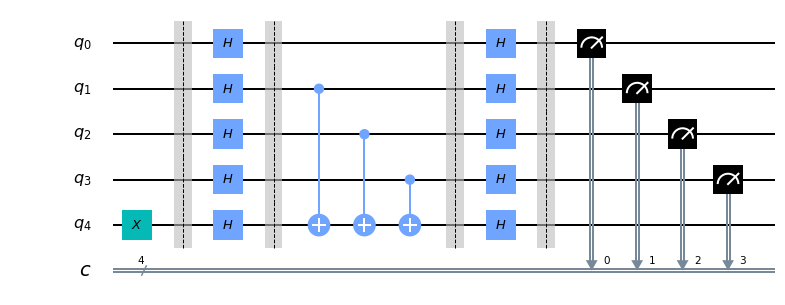

In [3]:
secret1 = '1110'
n = len(secret1)
circuit1 = QuantumCircuit(n+1,n)
Bernstein_V (n, secret1,circuit1)
circuit1.draw(output='mpl')

### Circuito para los bits menos significativos s = "1101"

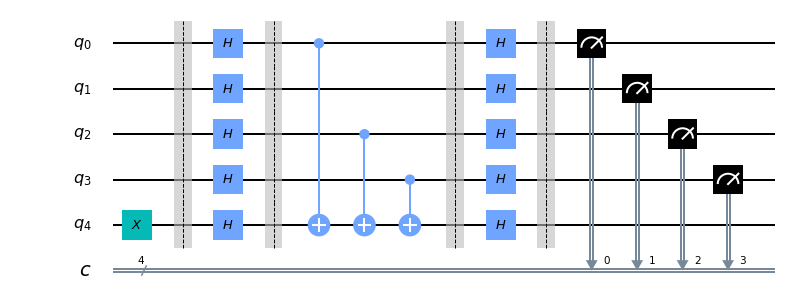

In [4]:
secret2 = '1101'
n2 = len(secret2)
circuit2 = QuantumCircuit(n2+1,n2)
Bernstein_V (n2, secret2,circuit2)
circuit2.draw(output='mpl')

## Simulación de ambos circuitos y resultados 

In [5]:
simulator = Aer.get_backend('qasm_simulator')
result1 = execute(circuit1, backend=simulator, shots=1).result()

In [6]:
simulator = Aer.get_backend('qasm_simulator')
result2 = execute(circuit2, backend=simulator, shots=1).result()

## s = "1110"

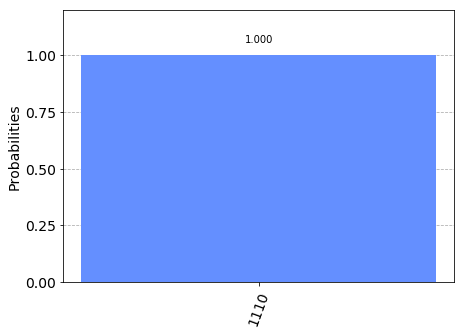

In [41]:
plot_histogram(result1.get_counts(circuit1))

## s = "1101"

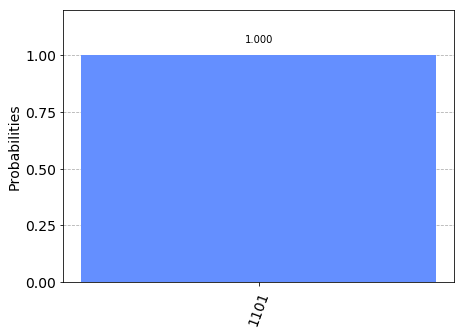

In [8]:
plot_histogram(result2.get_counts(circuit2))

## Ejecución en máquina real

In [33]:
## se carga la cuenta de IBM y la maquina en el que será ejecutado
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend =provider.get_backend('ibmq_london')

Credentials are already in use. The existing account in the session will be replaced.


In [13]:
shots = 8192
job1 = execute(circuit1, backend=backend, shots=shots)
job_monitor(job1, interval = 2)

Job Status: job has successfully run


## Resultado de la ejecución para cadena de bit más significativa s = "1110"

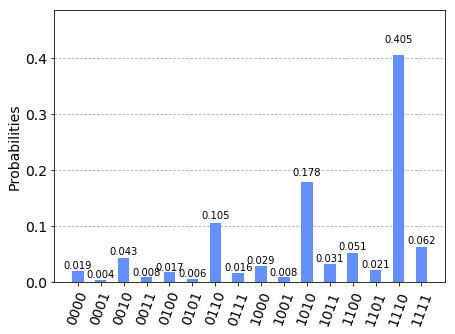

In [14]:
results1_1 = job1.result()
answer1 = results1_1.get_counts()

plot_histogram(answer1)

In [34]:
job2 = execute(circuit2, backend=backend, shots=shots)
job_monitor(job2, interval = 2)

Job Status: job has successfully run


## Resultado de la ejecución para cadena de bit menos significativa  s = "1101"

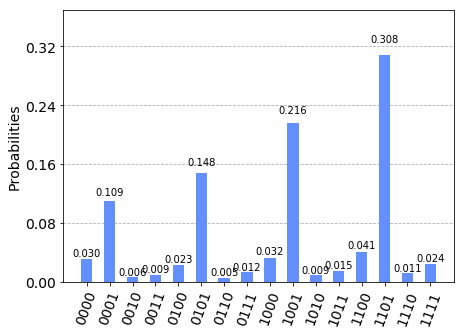

In [35]:
results2_2 = job2.result()
answer2 = results2_2.get_counts()
plot_histogram(answer2)

## Mitigación en el error de medida

Una de las técnicas utilizadas, para mitigar el error en la medida es preparar cada uno de los estados base con un error muy bajo en la probabilidad de la medida. Normalizando estas salidas y haciendo cada conjunto de probabilidades de salida para un estado preparado se construye  una matriz |A|, que traduce la distribución de probabilidad ideal del estado ($P_\rho$), en la distribución de probabilidad de la  medida experimental $\tilde{P}_{\rho}$, es decir la distribución de probabilidad del circuito que se desea mitigar, este proceso es llamado calibración por medio de la matriz |A| en el elemento de medida.

$$\tilde{P}_{\rho} = \mathbf{A} \cdot P_{\rho}$$

Como se desea es aproximar el resultado experimental ($\tilde{P}_{\rho}$) al ideal ( $P_{\rho}$ ), se necesita invertir  $\mathbf{A}$:

$$P_{\rho} = \mathbf{A}^{-1} \cdot \tilde{P}_{\rho}$$

la cual será la mitigación realizada al error en la medida del circuito.

Para realizar este proceso,se utiliza la librería de ingnis en qiskt, con las funciones complete_meas_cal para generar la calibración del elemento de medida y CompleteMeasFitter que permite crear la matriz, que "filtrará" los resultados experimentales de cada circuito, con respecto a los ideales.


In [21]:
#Se genera el circuito que permite la calibración del elemento de medida.
cal_circuits, state_labels = complete_meas_cal( qubit_list =[0,1,2,3], qr=None,circlabel='measurement_calibration')

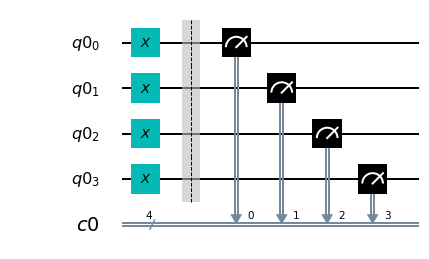

In [22]:
cal_circuits[15].draw(output='mpl')

In [23]:
#Se ejecuta en una máquina real
cal_job = execute(cal_circuits,backend=backend,shots=8192)
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


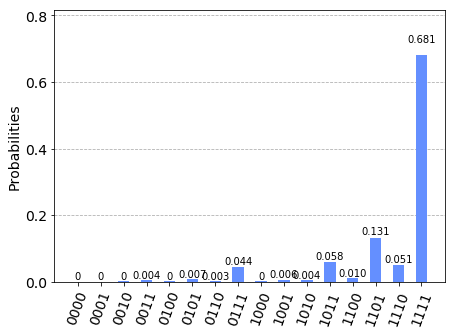

In [24]:
cal_results = cal_job.result()
plot_histogram(cal_results.get_counts(cal_circuits[15]))

In [25]:
#se crea la matriz de calibración
meas_fitter = CompleteMeasFitter(cal_results, state_labels)  

In [26]:
meas_filter = meas_fitter.filter

In [27]:
#Se aplica matriz de calibración a los resultados experimental del circuito 1 para los bits más significativos
mitigated_result1 = meas_filter.apply(results1_1)

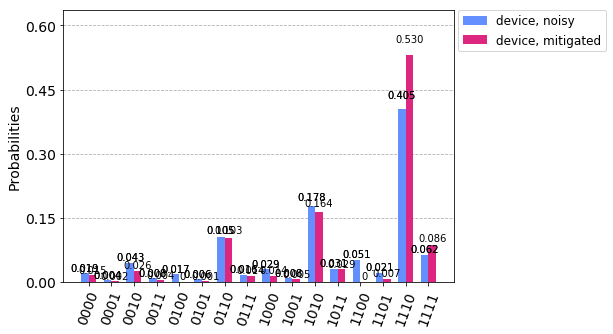

In [28]:
device_counts = results1_1.get_counts(circuit1)
mitigated_counts = mitigated_result1.get_counts(circuit1)
plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])

In [36]:
#Se aplica matriz de calibración a los resultados experimental del circuito 2 para los bits menos significativos
mitigated_result2 = meas_filter.apply(results2_2)

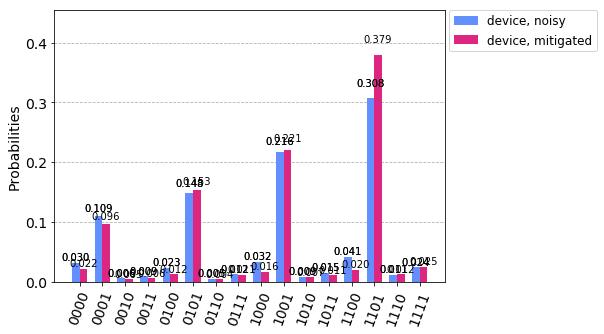

In [37]:
device_counts = results2_2.get_counts(circuit2)
mitigated_counts = mitigated_result2.get_counts(circuit2)
plot_histogram([device_counts, mitigated_counts], 
               legend=['device, noisy', 'device, mitigated'])